In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
import addict
import copy
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import List, Dict, Tuple
from scipy.optimize import lsq_linear

# import scipy.sparse.linalg
from scipy.sparse import csr_matrix

import celeri

plt.rcParams["text.usetex"] = False

##### Read input, create data structures, close blocks


In [3]:
COMMAND_FILE_NAME = "../data/command/western_north_america_command.json"
command = celeri.get_command(COMMAND_FILE_NAME)
celeri.create_output_folder(command)
logger = celeri.get_logger(command)
segment, block, meshes, station, mogi, sar = celeri.read_data(command)

# Hack
segment.locking_depth = 15
segment.burial_depth = 0
segment.locking_depth.values[segment.patch_flag == 1] = 0
segment.burial_depth.values[segment.patch_flag == 1] = 0

station = celeri.process_station(station, command)
segment = celeri.process_segment(segment, command, meshes)
sar = celeri.process_sar(sar, command)
closure, block = celeri.assign_block_labels(segment, station, block, mogi, sar)
assembly = addict.Dict()
operators = addict.Dict()
operators.meshes = [addict.Dict()] * len(meshes)
assembly = celeri.merge_geodetic_data(assembly, station, sar)

2024-06-21 13:40:53.058 | INFO     | celeri.celeri:get_logger:128 - Read: ../data/command/western_north_america_command.json
2024-06-21 13:40:53.058 | INFO     | celeri.celeri:get_logger:129 - RUN_NAME: 2024-06-21-13-40-53
2024-06-21 13:40:53.059 | INFO     | celeri.celeri:get_logger:130 - Write log file: ../runs/2024-06-21-13-40-53/2024-06-21-13-40-53.log
2024-06-21 13:40:53.059 | INFO     | celeri.celeri:read_data:135 - Reading data files
2024-06-21 13:40:53.065 | SUCCESS  | celeri.celeri:read_data:139 - Read: ../data/segment/western_north_america_segment.csv
2024-06-21 13:40:53.067 | SUCCESS  | celeri.celeri:read_data:144 - Read: ../data/block/western_north_america_block.csv
2024-06-21 13:40:53.067 | SUCCESS  | celeri.celeri:read_data:151 - Read: ../data/mesh/western_north_america_mesh_parameters.json



Warning: The file contains tag data that couldn't be processed.

2024-06-21 13:40:53.093 | SUCCESS  | celeri.celeri:read_data:272 - Read: ../data/mesh/cascadia.msh
2024-06-21 13:40:53.096 | SUCCESS  | celeri.celeri:read_data:308 - Read: ../data/station/western_north_america_station.csv
2024-06-21 13:40:53.097 | INFO     | celeri.celeri:read_data:323 - No mogi_file_name
2024-06-21 13:40:53.098 | INFO     | celeri.celeri:read_data:345 - No sar_file_name


##### Get elastic operators and TDE smoothing operators


In [4]:
# Get all elastic operators for segments and TDEs
celeri.get_elastic_operators(operators, meshes, segment, station, command)

# Get TDE smoothing operators
celeri.get_all_mesh_smoothing_matrices(meshes, operators)

2024-06-21 13:40:53.817 | INFO     | celeri.celeri:get_elastic_operators:1530 - Using precomputed elastic operators


##### Calculate non-elastic operators


In [5]:
n_blocks = len(block)
operators.rotation_to_velocities = celeri.get_rotation_to_velocities_partials(
    station, n_blocks
)
operators.global_float_block_rotation = celeri.get_global_float_block_rotation_partials(
    station
)
assembly, operators.block_motion_constraints = celeri.get_block_motion_constraints(
    assembly, block, command
)
assembly, operators.slip_rate_constraints = celeri.get_slip_rate_constraints(
    assembly, segment, block, command
)
operators.rotation_to_slip_rate = celeri.get_rotation_to_slip_rate_partials(
    segment, block
)
(
    operators.block_strain_rate_to_velocities,
    strain_rate_block_index,
) = celeri.get_block_strain_rate_to_velocities_partials(block, station, segment)
operators.mogi_to_velocities = celeri.get_mogi_to_velocities_partials(
    mogi, station, command
)
celeri.get_tde_slip_rate_constraints(meshes, operators)

2024-06-21 13:40:54.428 | INFO     | celeri.celeri:get_slip_rate_constraints:1169 - Found 1 slip rate constraints
2024-06-21 13:40:54.432 | INFO     | celeri.celeri:get_slip_rate_constraints:1172 - Strike-slip rate constraint on cfm_san_andreas_mojave_extruded_trace_part1_sa: rate = -50.00 (mm/yr), 1-sigma uncertainty = +/-1.00 (mm/yr)


##### Plot input data


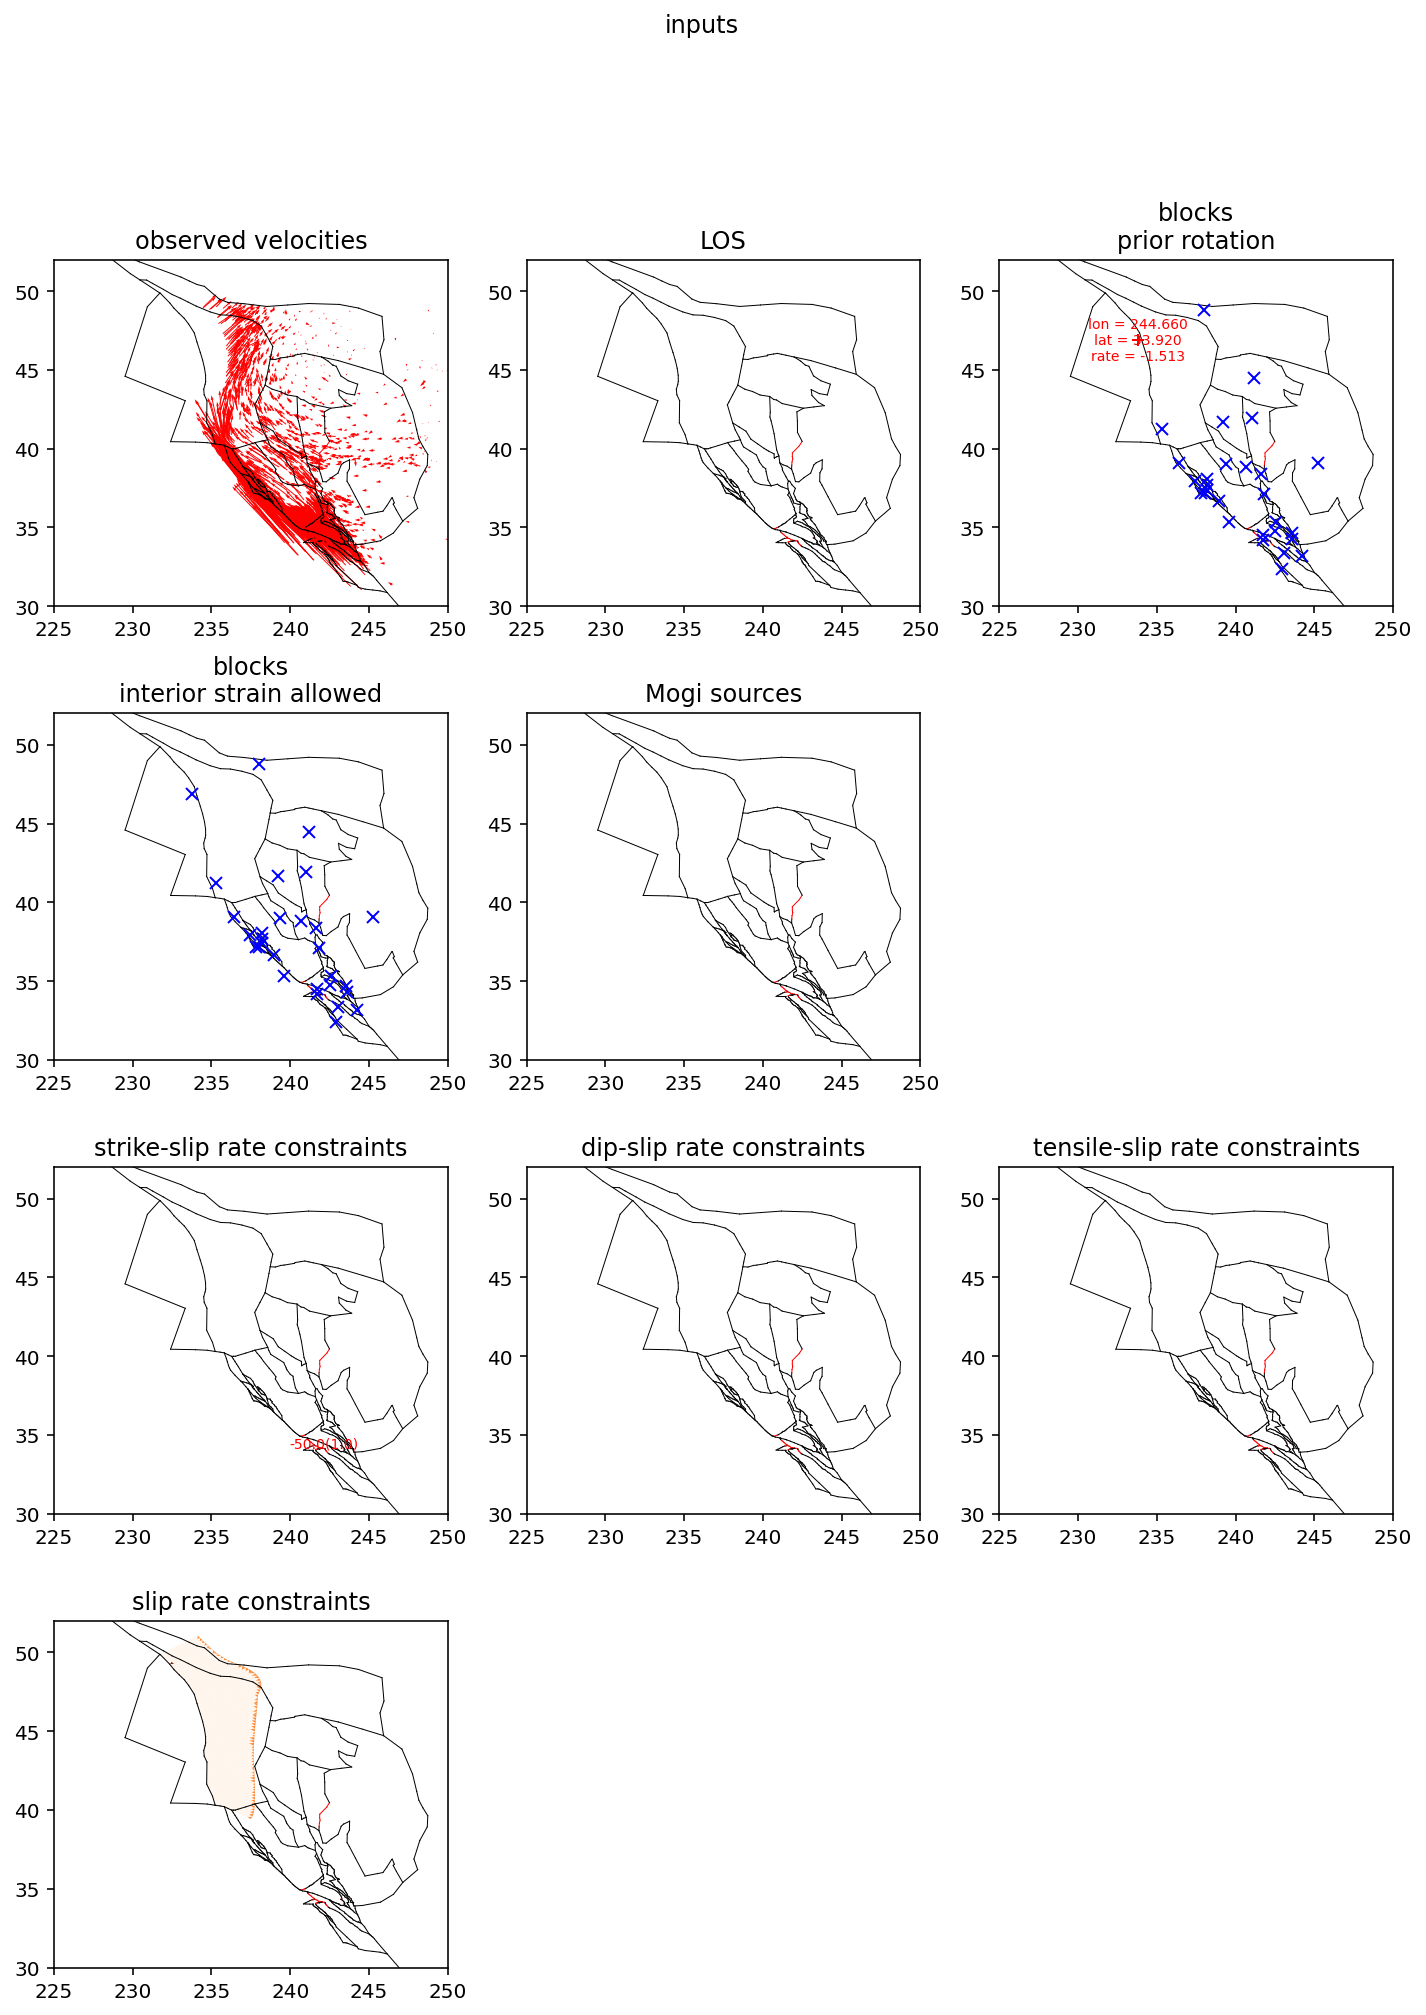

2024-06-21 13:40:58.262 | SUCCESS  | celeri.celeri:plot_input_summary:4415 - Wrote figures../runs/2024-06-21-13-40-53/plot_input_summary.(pdf, png)


<Figure size 432x288 with 0 Axes>

In [6]:
celeri.plot_input_summary(
    command,
    segment,
    station,
    block,
    meshes,
    mogi,
    sar,
    lon_range=command.lon_range,
    lat_range=command.lat_range,
    quiver_scale=command.quiver_scale,
)

# 1. Full direct dense block model solve


In [7]:
index = celeri.get_index(assembly, station, block, meshes)
estimation = addict.Dict()
estimation.data_vector = celeri.get_data_vector(assembly, index, meshes)
estimation.weighting_vector = celeri.get_weighting_vector(
    command, station, meshes, index
)
estimation.operator = celeri.get_full_dense_operator(operators, meshes, index)

# Solve the overdetermined linear system using only a weighting vector rather than matrix
tic = time.time()
estimation.state_covariance_matrix = np.linalg.inv(
    estimation.operator.T * estimation.weighting_vector @ estimation.operator
)
estimation.state_vector = (
    estimation.state_covariance_matrix
    @ estimation.operator.T
    * estimation.weighting_vector
    @ estimation.data_vector
)
toc = time.time()
print(f"Elapsed time: {toc - tic}")

celeri.post_process_estimation(estimation, operators, station, index)
celeri.write_output(command, estimation, station, segment, block, meshes)

Elapsed time: 1.9654052257537842


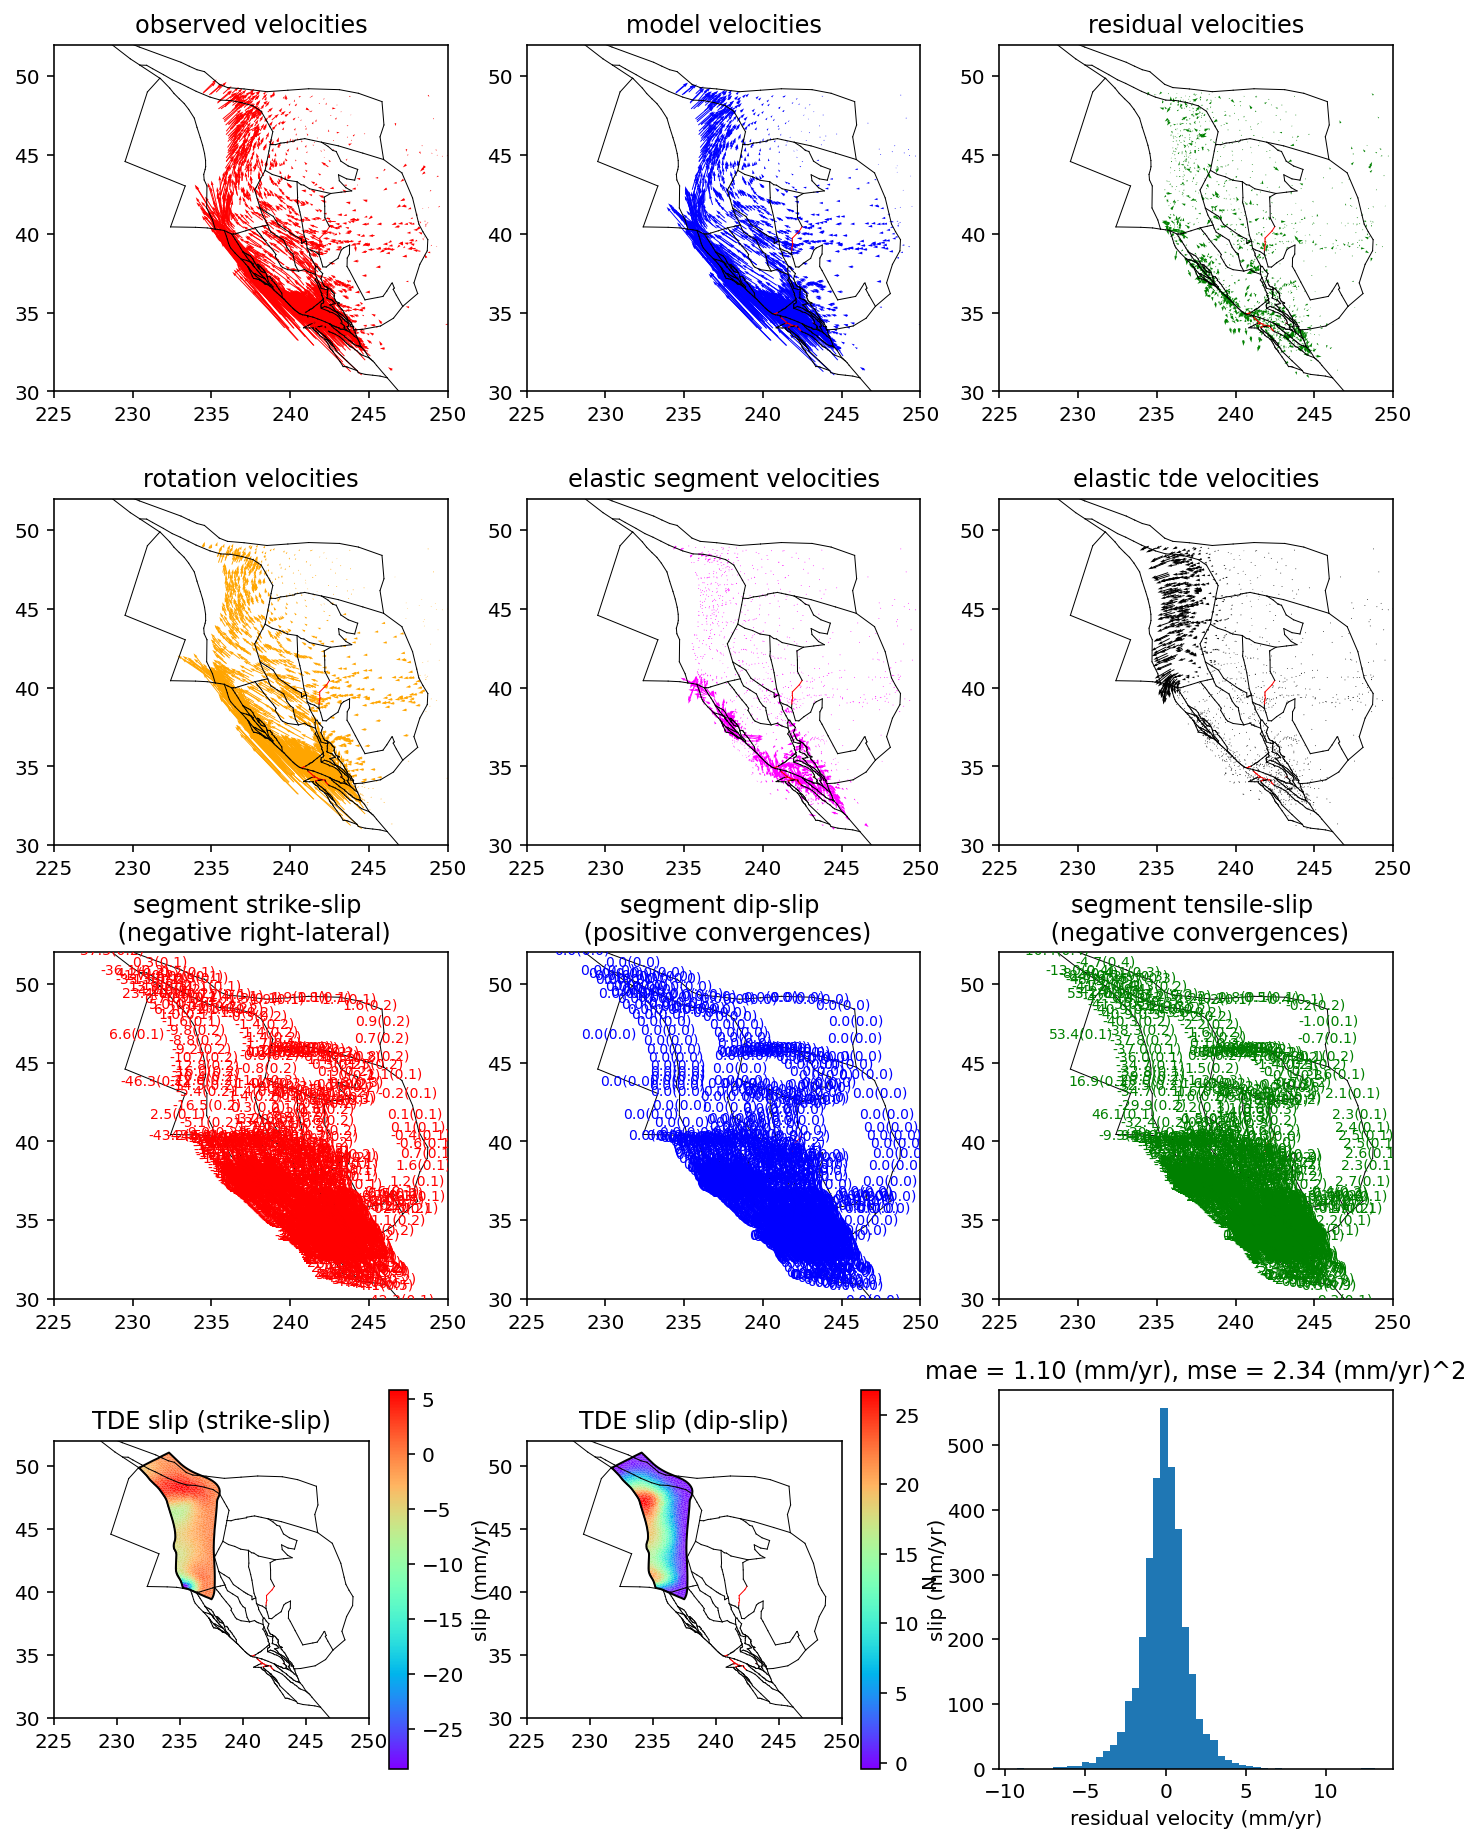

2024-06-21 13:41:07.878 | SUCCESS  | celeri.celeri:plot_estimation_summary:4915 - Wrote figures../runs/2024-06-21-13-40-53/plot_estimation_summary.(pdf, png)


<Figure size 432x288 with 0 Axes>

In [8]:
celeri.plot_estimation_summary(
    command,
    segment,
    station,
    meshes,
    estimation,
    lon_range=command.lon_range,
    lat_range=command.lat_range,
    quiver_scale=command.quiver_scale,
)

# Start of iterative attempt

In [9]:
# Are any TDE constraints violated?
lower_bound = np.zeros_like(estimation.state_vector)
upper_bound = np.zeros_like(estimation.state_vector)
lower_bound[:] = -np.inf
upper_bound[:] = np.inf

# TDE strike-slip
lower_bound[index.start_tde_col[0] : index.end_tde_col[0] : 2] = -5
upper_bound[index.start_tde_col[0] : index.end_tde_col[0] : 2] = 5

# TDE dip-slip
lower_bound[index.start_tde_col[0] + 1 : index.end_tde_col[0] : 2] = 0
upper_bound[index.start_tde_col[0] + 1 : index.end_tde_col[0] : 2] = 30


lower_bound_tde_only = lower_bound[3 * n_blocks : :]
upper_bound_tde_only = upper_bound[3 * n_blocks : :]


for i in range(3):
    print(i)
    # Lower bound TDE slack
    lb_slack = estimation.tde_rates - lower_bound_tde_only
    if np.any(lb_slack < 0):
        violation_idx = np.argmax(np.abs(lb_slack))
        print("Lower bound violated:")
        print(f"{violation_idx=}")
    # lb_slack_min = np.min(lb_slack)
    # lb_slack_max = np.max(lb_slack)

    # Is either residual larger

    # Upper bound TDE slack
    ub_slack = estimation.tde_rates - upper_bound[3 * n_blocks : :]

#     celeri.get_tde_slip_rate_constraints(meshes, operators)

0
Lower bound violated:
violation_idx=143
1
Lower bound violated:
violation_idx=143
2
Lower bound violated:
violation_idx=143


In [10]:
__author__ = "Valeriy Vishnevskiy", "Michael Hirsch"
__email__ = "valera.vishnevskiy@yandex.ru"
__version__ = "1.0"
__date__ = "22.11.2013"
__license__ = "MIT"

import numpy as np
from cvxopt import solvers, matrix, spmatrix
from scipy import sparse


def scipy_sparse_to_spmatrix(A):
    coo = A.tocoo()
    SP = spmatrix(coo.data, coo.row.tolist(), coo.col.tolist())
    return SP


def spmatrix_sparse_to_scipy(A):
    data = np.array(A.V).squeeze()
    rows = np.array(A.I).squeeze()
    cols = np.array(A.J).squeeze()
    return sparse.coo_matrix((data, (rows, cols)))


def sparse_None_vstack(A1, A2):
    if A1 is None:
        return A2
    else:
        return sparse.vstack([A1, A2])


def numpy_None_vstack(A1, A2):
    if A1 is None:
        return A2
    elif isinstance(A1, np.ndarray):
        return np.vstack([A1, A2])
    elif isinstance(A1, spmatrix):
        return np.vstack([cvxopt_to_numpy_matrix(A1).todense(), A2])


def numpy_None_concatenate(A1, A2):
    if A1 is None:
        return A2
    else:
        return np.concatenate([A1, A2])


def get_shape(A):
    if isinstance(A, spmatrix):
        return A.size
    else:
        return A.shape


def numpy_to_cvxopt_matrix(A):
    if A is None:
        return

    if sparse.issparse(A):
        if isinstance(A, sparse.spmatrix):
            return scipy_sparse_to_spmatrix(A)
        else:
            return A
    else:
        if isinstance(A, np.ndarray):
            if A.ndim == 1:
                return matrix(A, (A.shape[0], 1), "d")
            else:
                return matrix(A, A.shape, "d")
        else:
            return A


def cvxopt_to_numpy_matrix(A):
    if A is None:
        return
    if isinstance(A, spmatrix):
        return spmatrix_sparse_to_scipy(A)
    elif isinstance(A, matrix):
        return np.asarray(A).squeeze()
    else:
        return np.asarray(A).squeeze()


def lsqlin(
    C,
    d,
    reg=0,
    A=None,
    b=None,
    Aeq=None,
    beq=None,
    lb=None,
    ub=None,
    x0=None,
    opts=None,
):
    """
    Solve linear constrained l2-regularized least squares. Can
    handle both dense and sparse matrices. Matlab's lsqlin
    equivalent. It is actually wrapper around CVXOPT QP solver.

        min_x ||C*x  - d||^2_2 + reg * ||x||^2_2
        s.t.  A * x <= b
              Aeq * x = beq
              lb <= x <= ub

    Input arguments:
        C   is m x n dense or sparse matrix
        d   is n x 1 dense matrix
        reg is regularization parameter
        A   is p x n dense or sparse matrix
        b   is p x 1 dense matrix
        Aeq is q x n dense or sparse matrix
        beq is q x 1 dense matrix
        lb  is n x 1 matrix or scalar
        ub  is n x 1 matrix or scalar

    Output arguments:
        Return dictionary, the output of CVXOPT QP.

    Dont pass matlab-like empty lists to avoid setting parameters,
    just use None:
        lsqlin(C, d, 0.05, None, None, Aeq, beq) #Correct
        lsqlin(C, d, 0.05, [], [], Aeq, beq) #Wrong!
    """
    if sparse.issparse(A):  # detects both np and cxopt sparse
        sparse_case = True
        # We need A to be scipy sparse, as I couldn't find how
        # CVXOPT spmatrix can be vstacked
        if isinstance(A, spmatrix):
            A = spmatrix_sparse_to_scipy(A)
    else:
        sparse_case = False

    C = numpy_to_cvxopt_matrix(C)
    d = numpy_to_cvxopt_matrix(d)
    Q = C.T * C
    q = -d.T * C
    nvars = C.size[1]

    if reg > 0:
        if sparse_case:
            i = scipy_sparse_to_spmatrix(sparse.eye(nvars, nvars, format="coo"))
        else:
            i = matrix(np.eye(nvars), (nvars, nvars), "d")
        Q = Q + reg * i

    lb = cvxopt_to_numpy_matrix(lb)
    ub = cvxopt_to_numpy_matrix(ub)
    b = cvxopt_to_numpy_matrix(b)

    if lb is not None:  # Modify 'A' and 'b' to add lb inequalities
        if lb.size == 1:
            lb = np.repeat(lb, nvars)

        if sparse_case:
            lb_A = -sparse.eye(nvars, nvars, format="coo")
            A = sparse_None_vstack(A, lb_A)
        else:
            lb_A = -np.eye(nvars)
            A = numpy_None_vstack(A, lb_A)
        b = numpy_None_concatenate(b, -lb)
    if ub is not None:  # Modify 'A' and 'b' to add ub inequalities
        if ub.size == 1:
            ub = np.repeat(ub, nvars)
        if sparse_case:
            ub_A = sparse.eye(nvars, nvars, format="coo")
            A = sparse_None_vstack(A, ub_A)
        else:
            ub_A = np.eye(nvars)
            A = numpy_None_vstack(A, ub_A)
        b = numpy_None_concatenate(b, ub)

    # Convert data to CVXOPT format
    A = numpy_to_cvxopt_matrix(A)
    Aeq = numpy_to_cvxopt_matrix(Aeq)
    b = numpy_to_cvxopt_matrix(b)
    beq = numpy_to_cvxopt_matrix(beq)

    # Set up options
    if opts is not None:
        for k, v in opts.items():
            solvers.options[k] = v

    # Run CVXOPT.SQP solver
    sol = solvers.qp(Q, q.T, A, b, Aeq, beq, None, x0)
    return sol


def lsqnonneg(C, d, opts):
    """
    Solves nonnegative linear least-squares problem:

    min_x ||C*x - d||_2^2,  where x >= 0
    """
    return lsqlin(
        C,
        d,
        reg=0,
        A=None,
        b=None,
        Aeq=None,
        beq=None,
        lb=0,
        ub=None,
        x0=None,
        opts=opts,
    )

In [11]:
# Testing
C = np.array(
    [
        [0.9501, 0.7620, 0.6153, 0.4057],
        [0.2311, 0.4564, 0.7919, 0.9354],
        [0.6068, 0.0185, 0.9218, 0.9169],
        [0.4859, 0.8214, 0.7382, 0.4102],
        [0.8912, 0.4447, 0.1762, 0.8936],
    ]
)
A = np.array(
    [
        [0.2027, 0.2721, 0.7467, 0.4659],
        [0.1987, 0.1988, 0.4450, 0.4186],
        [0.6037, 0.0152, 0.9318, 0.8462],
    ]
)
d = np.array([0.0578, 0.3528, 0.8131, 0.0098, 0.1388])
b = np.array([0.5251, 0.2026, 0.6721])
lb = np.array([-0.1] * 4)
ub = np.array([2] * 4)

opts = {"show_progress": True}
ret = lsqlin(C, d, 0, A, b, None, None, lb, ub, None, opts)
print(ret["x"].T)
print("Should be [-1.00e-01 -1.00e-01  2.15e-01  3.50e-01]")

     pcost       dcost       gap    pres   dres
 0:  2.1237e-01 -1.0108e+01  4e+01  9e-01  4e+00
 1: -6.5628e-02 -3.8167e+00  4e+00  3e-16  5e-16
 2: -1.4194e-01 -7.0817e-01  6e-01  7e-17  3e-16
 3: -2.9343e-01 -4.2263e-01  1e-01  7e-17  1e-16
 4: -3.1805e-01 -3.2564e-01  8e-03  1e-16  2e-16
 5: -3.2032e-01 -3.2078e-01  5e-04  2e-16  9e-17
 6: -3.2056e-01 -3.2057e-01  8e-06  3e-16  5e-16
 7: -3.2057e-01 -3.2057e-01  8e-08  1e-16  1e-15
Optimal solution found.
[-1.00e-01 -1.00e-01  2.15e-01  3.50e-01]

Should be [-1.00e-01 -1.00e-01  2.15e-01  3.50e-01]


In [12]:
# Testing
C = np.array(
    [
        [0.9501, 0.7620, 0.6153, 0.4057],
        [0.2311, 0.4564, 0.7919, 0.9354],
        [0.6068, 0.0185, 0.9218, 0.9169],
        [0.4859, 0.8214, 0.7382, 0.4102],
        [0.8912, 0.4447, 0.1762, 0.8936],
    ]
)
A = np.array(
    [
        [0.2027, 0.2721, 0.7467, 0.4659],
        [0.1987, 0.1988, 0.4450, 0.4186],
        [0.6037, 0.0152, 0.9318, 0.8462],
    ]
)
d = np.array([0.0578, 0.3528, 0.8131, 0.0098, 0.1388])
b = np.array([0.5251, 0.2026, 0.6721])
lb = np.array([-0.1] * 4)
ub = np.array([2] * 4)

opts = {"show_progress": True}
ret = lsqlin(C, d, 0, None, None, None, None, None, None, None, opts)
print(ret["x"].T)
print("Should be [-1.00e-01 -1.00e-01  2.15e-01  3.50e-01]")

[ 1.89e-01 -7.17e-01  5.60e-01  2.11e-01]

Should be [-1.00e-01 -1.00e-01  2.15e-01  3.50e-01]


In [13]:
lower_bound = -np.ones_like(estimation.state_vector)
upper_bound = np.ones_like(estimation.state_vector)

# TDE strike-slip
lower_bound[index.start_tde_col[0] : index.end_tde_col[0] : 2] = -5
upper_bound[index.start_tde_col[0] : index.end_tde_col[0] : 2] = 5

# TDE dip-slip
lower_bound[index.start_tde_col[0] + 1 : index.end_tde_col[0] : 2] = 0
upper_bound[index.start_tde_col[0] + 1 : index.end_tde_col[0] : 2] = 30


# Unbounded
ret = lsqlin(
    estimation.operator * np.sqrt(estimation.weighting_vector[:, None]),
    estimation.data_vector * np.sqrt(estimation.weighting_vector),
    0,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    opts,
)

# Bounded TDE
tic = time.time()
ret = lsqlin(
    estimation.operator * np.sqrt(estimation.weighting_vector[:, None]),
    estimation.data_vector * np.sqrt(estimation.weighting_vector),
    0,
    None,
    None,
    None,
    None,
    lower_bound,
    upper_bound,
    None,
    opts,
)
toc = time.time()
print(f"Elapsed time: {toc - tic}")

     pcost       dcost       gap    pres   dres
 0: -3.4866e+14 -3.4866e+14  2e+06  2e-01  2e-23
 1: -3.4866e+14 -3.4866e+14  2e+05  1e-02  2e-23
 2: -3.4866e+14 -3.4866e+14  2e+04  1e-03  6e-24
 3: -3.4866e+14 -3.4866e+14  5e+03  1e-04  4e-24
 4: -3.4866e+14 -3.4866e+14  1e+03  2e-05  4e-24
 5: -3.4866e+14 -3.4866e+14  3e+02  5e-06  3e-24
 6: -3.4866e+14 -3.4866e+14  1e+02  1e-16  5e-24
Optimal solution found.
Elapsed time: 4.662674903869629


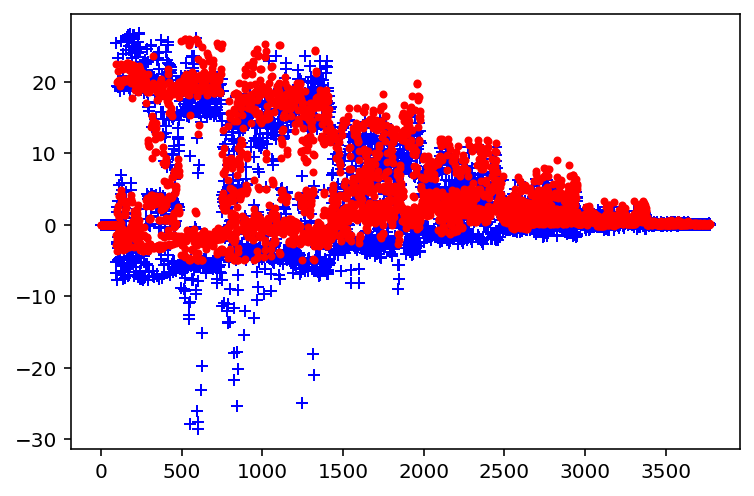

In [14]:
plt.plot(estimation.state_vector, "b+")
plt.plot(np.array(ret["x"]).flatten(), "r.")
ret_bounded = ret

In [15]:
np.array(ret["x"]).flatten().shape

(3775,)

n_eigen=100.0
eigenvectors_two_component.shape=(3682, 200)
operator.shape=(3519, 293)
Elapsed time: 0.007827043533325195


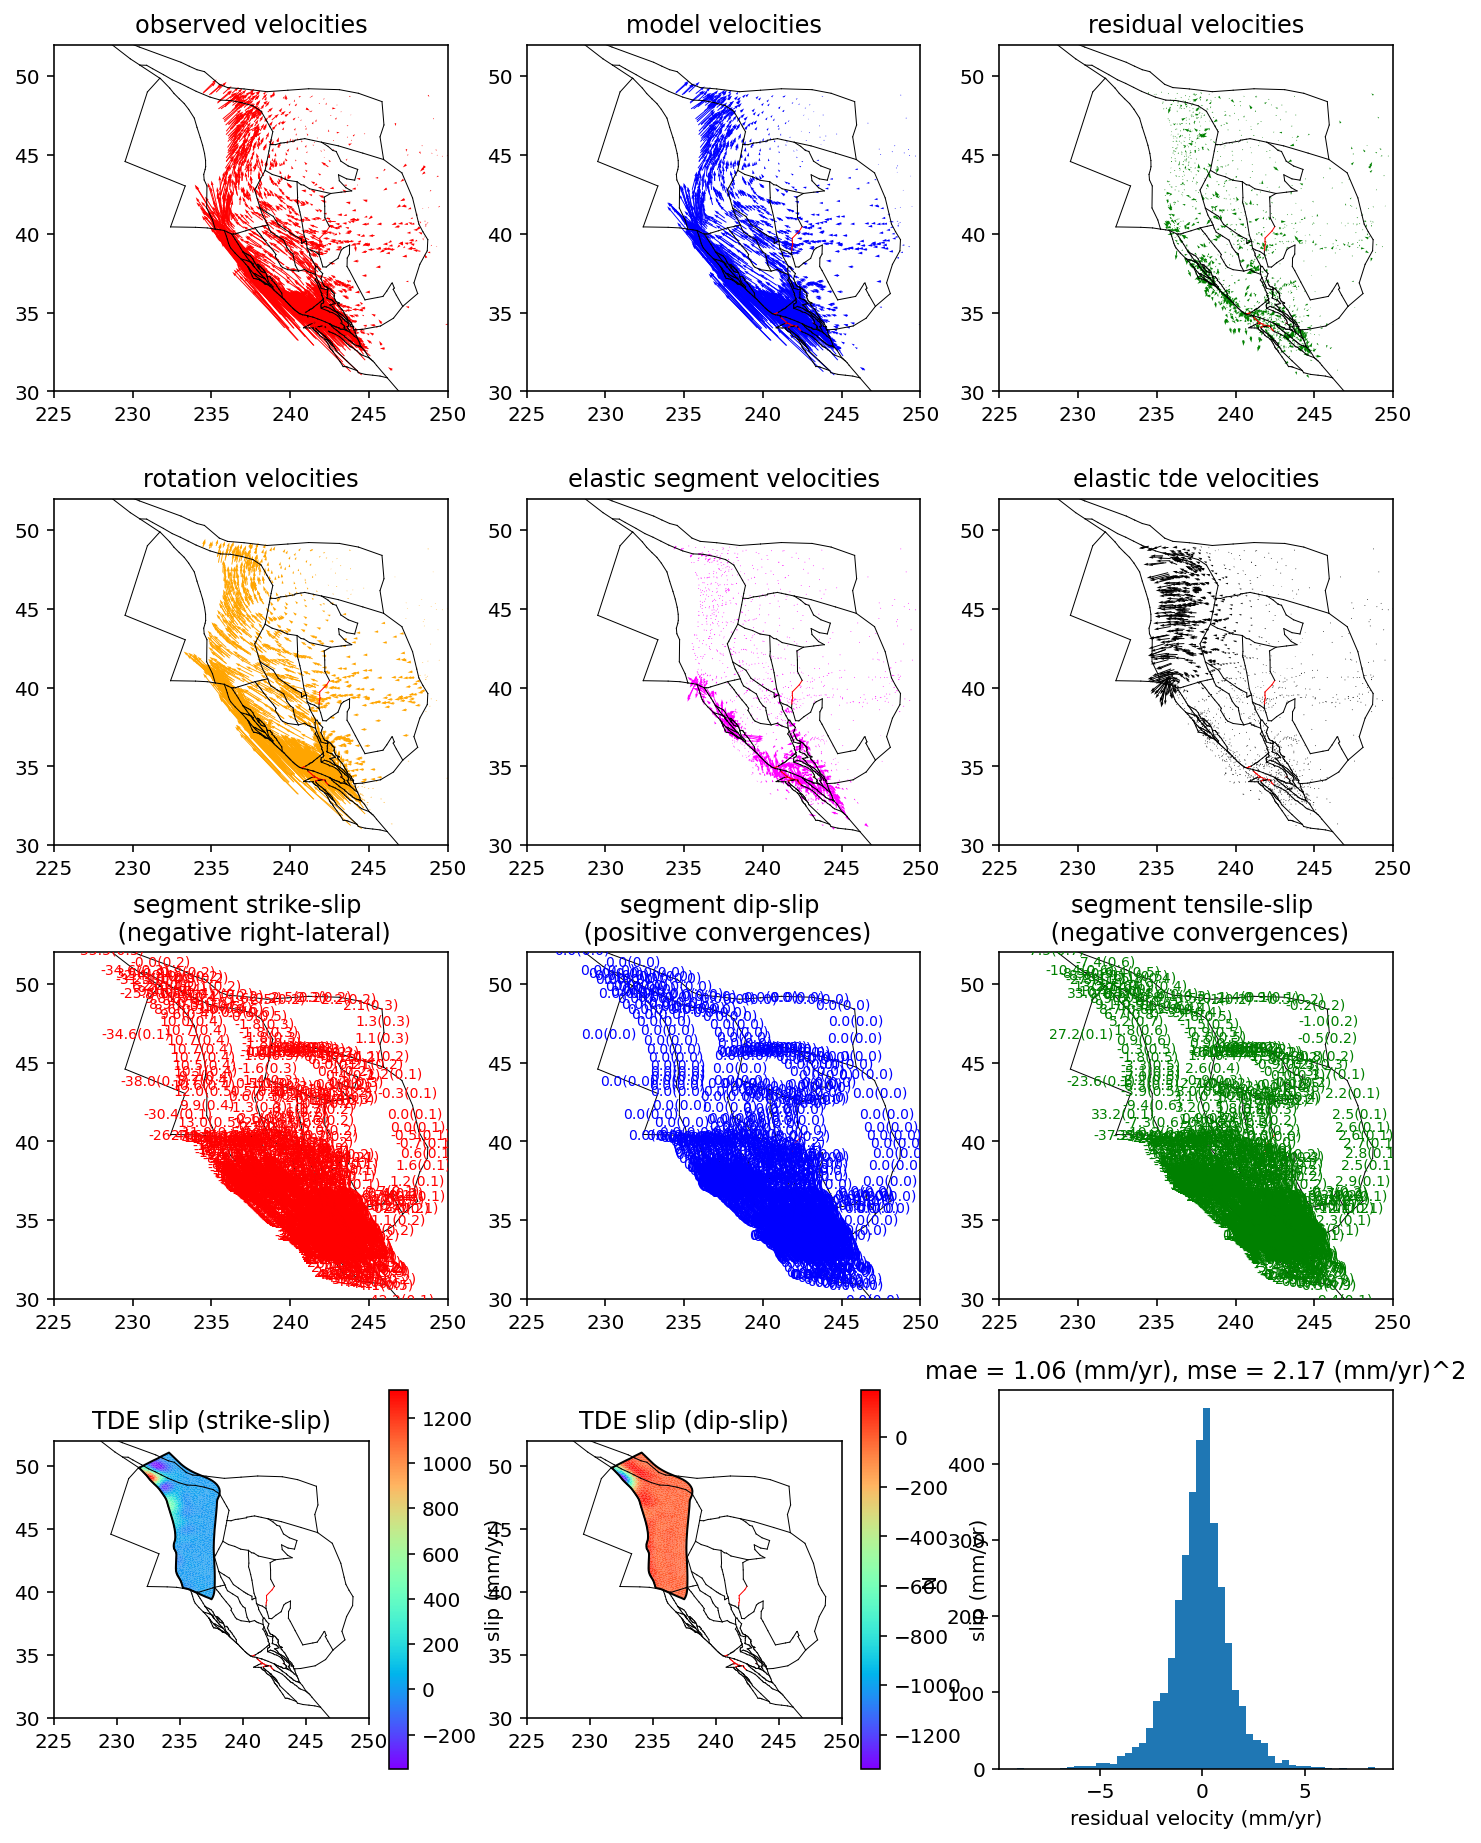

2024-06-21 13:41:22.285 | SUCCESS  | celeri.celeri:plot_estimation_summary:4915 - Wrote figures../runs/2024-06-21-13-40-53/plot_estimation_summary.(pdf, png)


<Figure size 432x288 with 0 Axes>

In [16]:
import scipy

meshes[0].n_eigen = 100


def get_eigenvalues_and_eigenvectors(n_eigenvalues, x, y, z):
    n_tde = x.size

    # Calculate Cartesian distances between triangle centroids
    centroid_coordinates = np.array([x, y, z]).T
    distance_matrix = scipy.spatial.distance.cdist(
        centroid_coordinates, centroid_coordinates, "euclidean"
    )

    # Rescale distance matrix to the range 0-1
    distance_matrix = (distance_matrix - np.min(distance_matrix)) / np.ptp(
        distance_matrix
    )

    # Calculate correlation matrix
    correlation_matrix = np.exp(-distance_matrix)

    # https://stackoverflow.com/questions/12167654/fastest-way-to-compute-k-largest-eigenvalues-and-corresponding-eigenvectors-with
    eigenvalues, eigenvectors = scipy.linalg.eigh(
        correlation_matrix,
        subset_by_index=[n_tde - n_eigenvalues, n_tde - 1],
    )
    eigenvalues = np.real(eigenvalues)
    eigenvectors = np.real(eigenvectors)
    ordered_index = np.flip(np.argsort(eigenvalues))
    eigenvalues = eigenvalues[ordered_index]
    eigenvectors = eigenvectors[:, ordered_index]
    return eigenvalues, eigenvectors


# Calculate eigenvales and eigenvectors for triangle subset
# n_eigenvalues = meshes[0].n_tde
# n_eigenvalues = 20


eigenvalues, eigenvectors = get_eigenvalues_and_eigenvectors(
    meshes[0].n_eigen,
    meshes[0].x_centroid,
    meshes[0].y_centroid,
    meshes[0].z_centroid,
)
# Create modified eigenvector matrix here
# This is a replication of the EVs for both slip components
# There are other ways to do this but as implemented is a sort of
# checkerboard like pattern.  The column indexing an every other
# row striding implements this.
eigenvectors_two_component = np.zeros(
    (2 * eigenvectors.shape[0], 2 * eigenvectors.shape[1])
)
for i in range(meshes[0].n_eigen):
    index_column_1 = 2 * i
    index_column_2 = 2 * i + 1
    eigenvectors_two_component[0::2, index_column_1] = eigenvectors[:, i]
    eigenvectors_two_component[1::2, index_column_2] = eigenvectors[:, i]
DEG_PER_MYR_TO_RAD_PER_YR = 1 / 1e6  # TODO: What should this conversion be?


def get_data_vector_eigen(assembly, index):
    data_vector = np.zeros(
        2 * index.n_stations
        + 3 * index.n_block_constraints
        + index.n_slip_rate_constraints
        + index.n_tde_constraints_total
    )

    # Add GPS stations to data vector
    data_vector[index.start_station_row : index.end_station_row] = celeri.interleave2(
        assembly.data.east_vel, assembly.data.north_vel
    )

    # Add block motion constraints to data vector
    data_vector[index.start_block_constraints_row : index.end_block_constraints_row] = (
        DEG_PER_MYR_TO_RAD_PER_YR * assembly.data.block_constraints
    )

    # Add slip rate constraints to data vector
    data_vector[
        index.start_slip_rate_constraints_row : index.end_slip_rate_constraints_row
    ] = assembly.data.slip_rate_constraints
    return data_vector


def get_weighting_vector_eigen(command, station, meshes, index):
    # Initialize and build weighting matrix
    weighting_vector = np.ones(
        2 * index.n_stations
        + 3 * index.n_block_constraints
        + index.n_slip_rate_constraints
        + index.n_tde_constraints_total
    )

    weighting_vector[index.start_station_row : index.end_station_row] = (
        celeri.interleave2(1 / (station.east_sig**2), 1 / (station.north_sig**2))
    )

    weighting_vector[
        index.start_block_constraints_row : index.end_block_constraints_row
    ] = command.block_constraint_weight

    weighting_vector[
        index.start_slip_rate_constraints_row : index.end_slip_rate_constraints_row
    ] = command.slip_constraint_weight * np.ones(index.n_slip_rate_constraints)

    for i in range(len(meshes)):
        # TODO: This is too hacky to keep.  Revise with no reference to smoothing
        weighting_vector[
            index.start_tde_smoothing_row[i] : index.start_tde_smoothing_row[i]
            + index.n_tde_constraints[i]
        ] = command.tri_con_weight * np.ones(index.n_tde_constraints[i])

    return weighting_vector


def get_full_dense_operator_eigen(operators, meshes, index):
    # Initialize linear operator

    n_eigen = eigenvectors_two_component.shape[1] / 2
    print(f"{n_eigen=}")

    operator = np.zeros(
        (
            2 * index.n_stations
            + 3 * index.n_block_constraints
            + index.n_slip_rate_constraints
            # + 2 * index.n_tde_total
            + index.n_tde_constraints_total,
            3 * index.n_blocks + 2 * int(n_eigen),
        )
    )
    print(f"{eigenvectors_two_component.shape=}")
    print(f"{operator.shape=}")

    # Insert block rotations and elastic velocities from fully locked segments
    operators.rotation_to_slip_rate_to_okada_to_velocities = (
        operators.slip_rate_to_okada_to_velocities @ operators.rotation_to_slip_rate
    )
    operator[
        index.start_station_row : index.end_station_row,
        index.start_block_col : index.end_block_col,
    ] = (
        operators.rotation_to_velocities[index.station_row_keep_index, :]
        - operators.rotation_to_slip_rate_to_okada_to_velocities[
            index.station_row_keep_index, :
        ]
    )

    # Insert block motion constraints
    operator[
        index.start_block_constraints_row : index.end_block_constraints_row,
        index.start_block_col : index.end_block_col,
    ] = operators.block_motion_constraints

    # Insert slip rate constraints
    operator[
        index.start_slip_rate_constraints_row : index.end_slip_rate_constraints_row,
        index.start_block_col : index.end_block_col,
    ] = operators.slip_rate_constraints

    # Insert eigenvector to velocity matrix
    tde_keep_row_index = celeri.get_keep_index_12(
        operators.tde_to_velocities[0].shape[0]
    )
    tde_keep_col_index = celeri.get_keep_index_12(
        operators.tde_to_velocities[0].shape[1]
    )
    eigen_to_velocities = (
        -operators.tde_to_velocities[0][tde_keep_row_index, :][:, tde_keep_col_index]
        @ eigenvectors_two_component
    )
    operator[
        index.start_station_row : index.end_station_row,
        index.start_tde_col[0] : index.start_tde_col[0] + 2 * meshes[0].n_eigen,
    ] = eigen_to_velocities

    # Insert eigenvector to TDE constraints matrix
    # TODO: Inherit weighting from mesh_parameters file
    NNN = 1e1
    eigen_to_tde_slip_rate_constraints = (
        NNN * operators.tde_slip_rate_constraints[0] @ eigenvectors_two_component
    )

    operator[
        index.start_slip_rate_constraints_row : index.start_slip_rate_constraints_row
        + index.n_tde_constraints_total,
        index.start_tde_col[0] : index.start_tde_col[0] + 2 * meshes[0].n_eigen,
    ] = eigen_to_tde_slip_rate_constraints

    # # Insert TDE to velocity matrix
    # for i in range(len(meshes)):
    #     # Insert TDE to velocity matrix
    #     tde_keep_row_index = celeri.get_keep_index_12(operators.tde_to_velocities[i].shape[0])
    #     tde_keep_col_index = celeri.get_keep_index_12(operators.tde_to_velocities[i].shape[1])
    #     operator[
    #         index.start_station_row : index.end_station_row,
    #         index.start_tde_col[i] : index.end_tde_col[i],
    #     ] = -operators.tde_to_velocities[i][tde_keep_row_index, :][
    #         :, tde_keep_col_index
    #     ]

    #     # # Insert TDE smoothing matrix
    #     # smoothing_keep_index = celeri.get_keep_index_12(
    #     #     operators.tde_to_velocities[i].shape[1]
    #     # )
    #     # operator[
    #     #     index.start_tde_smoothing_row[i] : index.end_tde_smoothing_row[i],
    #     #     index.start_tde_col[i] : index.end_tde_col[i],
    #     # ] = operators.smoothing_matrix[i].toarray()[smoothing_keep_index, :][
    #     #     :, smoothing_keep_index
    #     # ]

    #     # Insert TDE slip rate constraints into estimation operator
    #     operator[
    #         index.start_tde_constraint_row[i] : index.end_tde_constraint_row[i],
    #         index.start_tde_col[i] : index.end_tde_col[i],
    #     ] = operators.tde_slip_rate_constraints[i]
    return operator


data_vector = celeri.get_data_vector(assembly, index, meshes)
data_vector_eigen = get_data_vector_eigen(assembly, index)
weighting_vector = celeri.get_weighting_vector(command, station, meshes, index)
weighting_vector_eigen = get_weighting_vector_eigen(command, station, meshes, index)
operator = celeri.get_full_dense_operator(operators, meshes, index)
operator_eigen = get_full_dense_operator_eigen(operators, meshes, index)


def post_process_estimation_eigen(
    estimation_eigen: Dict, operators: Dict, station: pd.DataFrame, index: Dict
):
    """Calculate derived values derived from the block model linear estimate (e.g., velocities, undertainties)

    Args:
        estimation (Dict): Estimated state vector and model covariance
        operators (Dict): All linear operators
        station (pd.DataFrame): GPS station data
        idx (Dict): Indices and counts of data and array sizes
    """

    # TODO: Start working through this for the EV case
    estimation_eigen.eigenvalues = estimation_eigen.state_vector[3 * n_blocks : :]
    estimation_eigen.predictions = (
        estimation_eigen.operator @ estimation_eigen.state_vector
    )
    estimation_eigen.vel = estimation_eigen.predictions[0 : 2 * index.n_stations]
    estimation_eigen.east_vel = estimation_eigen.vel[0::2]
    estimation_eigen.north_vel = estimation_eigen.vel[1::2]

    # Estimate slip rate uncertainties
    estimation_eigen.slip_rate_sigma = np.sqrt(
        np.diag(
            operators.rotation_to_slip_rate
            @ estimation_eigen.state_covariance_matrix[
                0 : 3 * index.n_blocks, 0 : 3 * index.n_blocks
            ]
            @ operators.rotation_to_slip_rate.T
        )
    )  # I don't think this is correct because for the case when there is a rotation vector a priori
    estimation_eigen.strike_slip_rate_sigma = estimation_eigen.slip_rate_sigma[0::3]
    estimation_eigen.dip_slip_rate_sigma = estimation_eigen.slip_rate_sigma[1::3]
    estimation_eigen.tensile_slip_rate_sigma = estimation_eigen.slip_rate_sigma[2::3]

    # Calculate mean squared residual velocity
    estimation_eigen.east_vel_residual = estimation_eigen.east_vel - station.east_vel
    estimation_eigen.north_vel_residual = estimation_eigen.north_vel - station.north_vel

    # Extract TDE slip rates from state vector
    estimation_eigen.tde_rates = (
        eigenvectors_two_component @ estimation_eigen.state_vector[3 * n_blocks : :]
    )
    estimation_eigen.tde_strike_slip_rates = estimation_eigen.tde_rates[0::2]
    estimation_eigen.tde_dip_slip_rates = estimation_eigen.tde_rates[1::2]

    # Extract segment slip rates from state vector
    estimation_eigen.slip_rates = (
        operators.rotation_to_slip_rate
        @ estimation_eigen.state_vector[0 : 3 * index.n_blocks]
    )
    estimation_eigen.strike_slip_rates = estimation_eigen.slip_rates[0::3]
    estimation_eigen.dip_slip_rates = estimation_eigen.slip_rates[1::3]
    estimation_eigen.tensile_slip_rates = estimation_eigen.slip_rates[2::3]

    # Calculate rotation only velocities
    estimation_eigen.vel_rotation = (
        operators.rotation_to_velocities[index.station_row_keep_index, :]
        @ estimation_eigen.state_vector[0 : 3 * index.n_blocks]
    )
    estimation_eigen.east_vel_rotation = estimation_eigen.vel_rotation[0::2]
    estimation_eigen.north_vel_rotation = estimation_eigen.vel_rotation[1::2]

    # Calculate fully locked segment velocities
    estimation_eigen.vel_elastic_segment = (
        operators.rotation_to_slip_rate_to_okada_to_velocities[
            index.station_row_keep_index, :
        ]
        @ estimation_eigen.state_vector[0 : 3 * index.n_blocks]
    )
    estimation_eigen.east_vel_elastic_segment = estimation_eigen.vel_elastic_segment[
        0::2
    ]
    estimation_eigen.north_vel_elastic_segment = estimation_eigen.vel_elastic_segment[
        1::2
    ]

    # TODO: Calculate block strain rate velocities
    estimation_eigen.east_vel_block_strain_rate = np.zeros(len(station))
    estimation_eigen.north_vel_block_strain_rate = np.zeros(len(station))

    # Calculate TDE velocities
    estimation_eigen.vel_tde = np.zeros(2 * index.n_stations)
    for i in range(len(operators.tde_to_velocities)):

        tde_keep_row_index = celeri.get_keep_index_12(
            operators.tde_to_velocities[i].shape[0]
        )
        tde_keep_col_index = celeri.get_keep_index_12(
            operators.tde_to_velocities[i].shape[1]
        )
        estimation_eigen.vel_tde += (
            operators.tde_to_velocities[i][tde_keep_row_index, :][:, tde_keep_col_index]
            @ eigenvectors_two_component
            @ estimation_eigen.state_vector[
                index.start_tde_col[i] : index.end_tde_col[i]
            ]
            # @ estimation_eigen.eigenvalues
        )
    estimation_eigen.east_vel_tde = estimation_eigen.vel_tde[0::2]
    estimation_eigen.north_vel_tde = estimation_eigen.vel_tde[1::2]


# Solve the linear system
estimation_eigen = addict.Dict()
tic = time.time()
estimation_eigen.state_covariance_matrix = np.linalg.inv(
    operator_eigen.T * weighting_vector_eigen @ operator_eigen
)
estimation_eigen.state_vector = (
    estimation_eigen.state_covariance_matrix
    @ operator_eigen.T
    * weighting_vector_eigen
    @ data_vector_eigen
)
toc = time.time()
print(f"Elapsed time: {toc - tic}")

forward_data_vector_eigen = operator_eigen @ estimation_eigen.state_vector

estimation_eigen.operator = operator_eigen
post_process_estimation_eigen(estimation_eigen, operators, station, index)
celeri.plot_estimation_summary(
    command,
    segment,
    station,
    meshes,
    estimation_eigen,
    lon_range=command.lon_range,
    lat_range=command.lat_range,
    quiver_scale=command.quiver_scale,
)


# Make a pseudostate vector for the eigenvalue case (just for comparision)
estimation_eigen.pseudo_state_vector = np.zeros_like(estimation.state_vector)
estimation_eigen.pseudo_state_vector[0 : 3 * index.n_blocks] = (
    estimation_eigen.state_vector[0 : 3 * index.n_blocks]
)
estimation_eigen.pseudo_state_vector[3 * index.n_blocks : :] = (
    estimation_eigen.tde_rates
)

# CVXOPT solve of dense KL (unbounded)

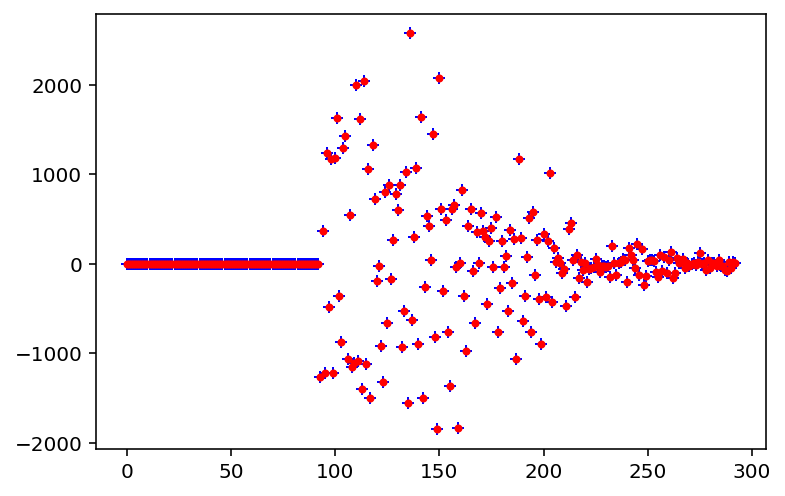

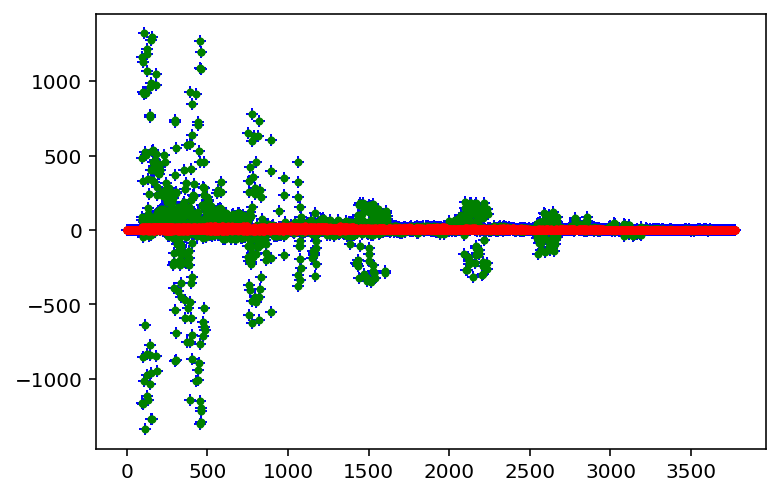

In [17]:
# Unbounded
ret = lsqlin(
    operator_eigen * np.sqrt(weighting_vector_eigen[:, None]),
    data_vector_eigen * np.sqrt(weighting_vector_eigen),
    0,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    opts,
)


# Make a pseudostate vector for the eigenvalue case (just for comparision)
ret_state_vector = np.array(ret["x"]).flatten()

estimation_eigen_ret = addict.Dict()
estimation_eigen_ret.state_covariance_matrix = np.linalg.inv(
    operator_eigen.T * weighting_vector_eigen @ operator_eigen
)
estimation_eigen_ret.state_vector = ret_state_vector
forward_data_vector_eigen = operator_eigen @ estimation_eigen_ret.state_vector
estimation_eigen_ret.operator = operator_eigen
post_process_estimation_eigen(estimation_eigen_ret, operators, station, index)


ret_pseudo_state_vector = np.zeros_like(estimation.state_vector)
ret_pseudo_state_vector[0 : 3 * index.n_blocks] = estimation_eigen_ret.state_vector[
    0 : 3 * index.n_blocks
]
ret_pseudo_state_vector[3 * index.n_blocks : :] = estimation_eigen_ret.tde_rates

plt.plot(estimation_eigen.state_vector, "b+")
plt.plot(np.array(ret["x"]).flatten(), "r.")
plt.show()

plt.plot(estimation_eigen.pseudo_state_vector, "b+")
plt.plot(ret_pseudo_state_vector, "g.")
plt.plot(np.array(ret_bounded["x"]).flatten(), "r.")

plt.show()

# CVXOPT solve of dense KL (bounded)

     pcost       dcost       gap    pres   dres
 0: -3.4991e+08 -3.5120e+08  2e+06  2e-01  8e-17
 1: -3.4991e+08 -3.5015e+08  2e+05  2e-02  5e-21
 2: -3.4992e+08 -3.5010e+08  2e+05  1e-02  3e-21
 3: -3.4992e+08 -3.5005e+08  1e+05  5e-03  2e-21
 4: -3.4992e+08 -3.4998e+08  6e+04  1e-03  3e-21
 5: -3.4992e+08 -3.4994e+08  3e+04  4e-04  4e-21
 6: -3.4992e+08 -3.4993e+08  1e+04  1e-04  2e-21
 7: -3.4992e+08 -3.4992e+08  3e+03  3e-05  2e-21
 8: -3.4992e+08 -3.4992e+08  3e+03  2e-05  2e-21
 9: -3.4992e+08 -3.4992e+08  1e+03  7e-06  3e-21
10: -3.4992e+08 -3.4992e+08  7e+02  2e-06  4e-21
11: -3.4992e+08 -3.4992e+08  3e+02  8e-07  4e-21
12: -3.4992e+08 -3.4992e+08  2e+02  2e-07  3e-21
13: -3.4992e+08 -3.4992e+08  7e+01  7e-08  2e-21
Optimal solution found.


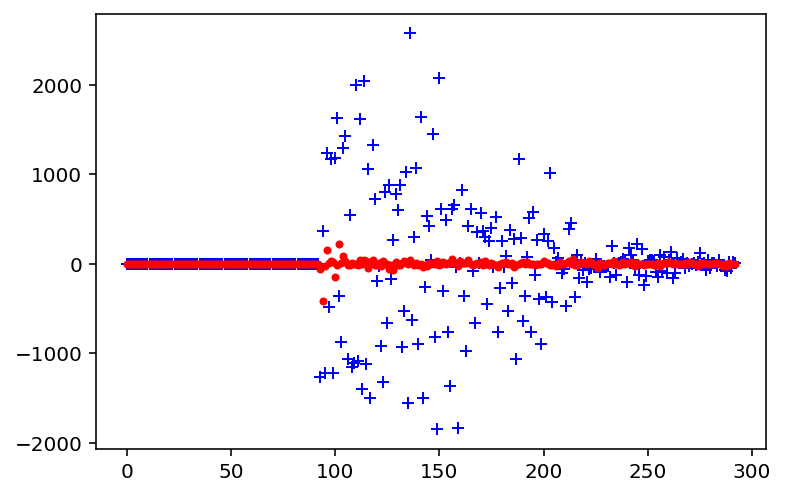

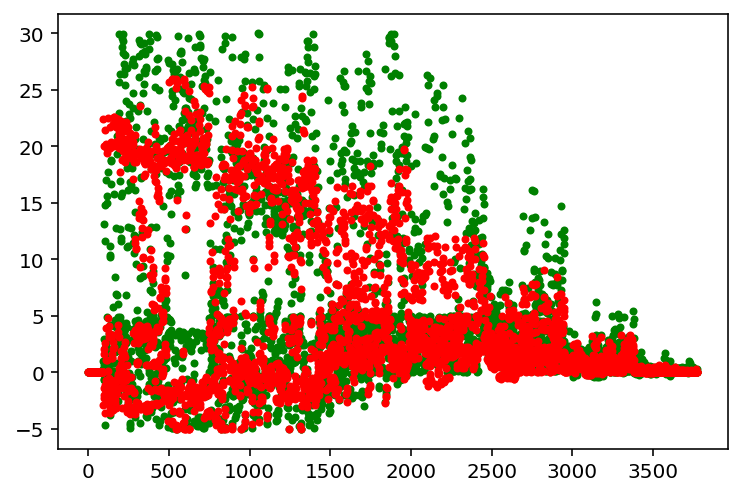

In [35]:
# Unbounded

K = np.zeros((eigenvectors_two_component.shape[0], ret_state_vector.shape[0]))
K[:, 3 * n_blocks :] = eigenvectors_two_component

A = np.zeros((2 * eigenvectors_two_component.shape[0], ret_state_vector.shape[0]))
A[0 : eigenvectors_two_component.shape[0], 3 * n_blocks :] = -eigenvectors_two_component
A[eigenvectors_two_component.shape[0] :, 3 * n_blocks :] = eigenvectors_two_component

b = np.zeros(2 * eigenvectors_two_component.shape[0])
b[0 : eigenvectors_two_component.shape[0]] = -lower_bound_tde_only
b[eigenvectors_two_component.shape[0] :] = upper_bound_tde_only

ret = lsqlin(
    operator_eigen * np.sqrt(weighting_vector_eigen[:, None]),
    data_vector_eigen * np.sqrt(weighting_vector_eigen),
    0,
    A,  # A=None, inequality operator
    b,  # b=None, inequality vector
    None,
    None,
    None,
    None,
    None,
    opts,
)


# ret = lsqlin(
#     operator_eigen * np.sqrt(weighting_vector_eigen[:, None]),
#     data_vector_eigen * np.sqrt(weighting_vector_eigen),
#     0,
#     K,  # A=None, inequality operator
#     upper_bound_tde_only,  # b=None, inequality vector
#     None,
#     None,
#     None,
#     None,
#     None,
#     opts,
# )


# Make a pseudostate vector for the eigenvalue case (just for comparision)
ret_state_vector = np.array(ret["x"]).flatten()

estimation_eigen_ret = addict.Dict()
estimation_eigen_ret.state_covariance_matrix = np.linalg.inv(
    operator_eigen.T * weighting_vector_eigen @ operator_eigen
)
estimation_eigen_ret.state_vector = ret_state_vector
forward_data_vector_eigen = operator_eigen @ estimation_eigen_ret.state_vector
estimation_eigen_ret.operator = operator_eigen
post_process_estimation_eigen(estimation_eigen_ret, operators, station, index)


ret_pseudo_state_vector = np.zeros_like(estimation.state_vector)
ret_pseudo_state_vector[0 : 3 * index.n_blocks] = estimation_eigen_ret.state_vector[
    0 : 3 * index.n_blocks
]
ret_pseudo_state_vector[3 * index.n_blocks : :] = estimation_eigen_ret.tde_rates

plt.plot(estimation_eigen.state_vector, "b+")
plt.plot(np.array(ret["x"]).flatten(), "r.")
plt.show()

# plt.plot(estimation_eigen.pseudo_state_vector, "b+")
plt.plot(ret_pseudo_state_vector, "g.")
plt.plot(np.array(ret_bounded["x"]).flatten(), "r.")

plt.show()

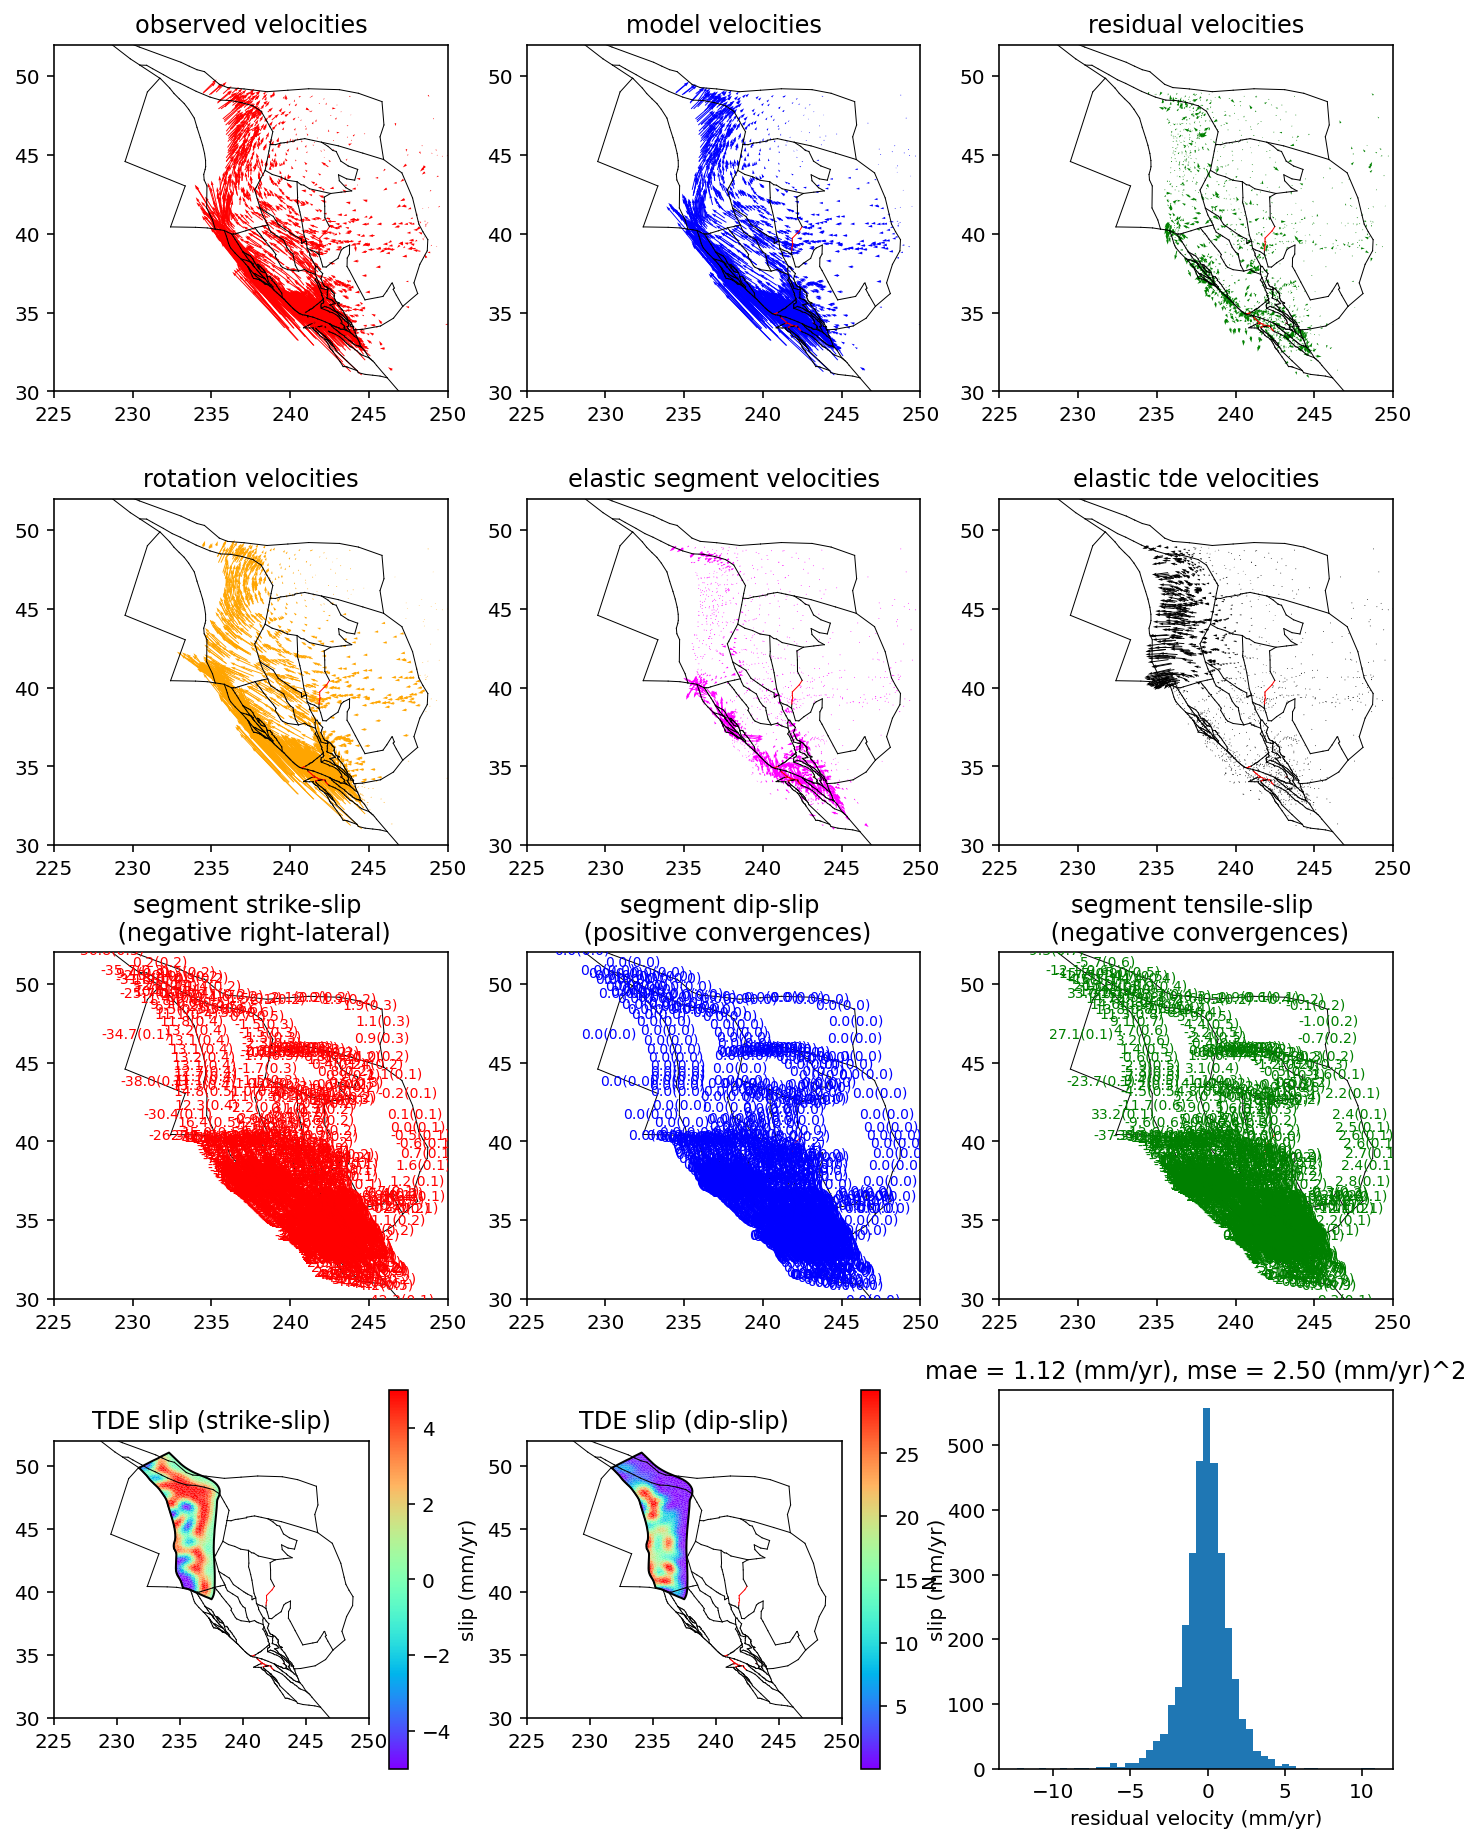

2024-06-21 13:54:13.688 | SUCCESS  | celeri.celeri:plot_estimation_summary:4915 - Wrote figures../runs/2024-06-21-13-40-53/plot_estimation_summary.(pdf, png)


<Figure size 432x288 with 0 Axes>

In [37]:
estimation_eigen.operator = operator_eigen
estimation_eigen.state_vector = ret_state_vector
post_process_estimation_eigen(estimation_eigen, operators, station, index)
celeri.plot_estimation_summary(
    command,
    segment,
    station,
    meshes,
    estimation_eigen,
    lon_range=command.lon_range,
    lat_range=command.lat_range,
    quiver_scale=command.quiver_scale,
)

In [53]:
A = np.zeros((2 * eigenvectors_two_component.shape[0], ret_state_vector.shape[0]))
A[0 : eigenvectors_two_component.shape[0], 3 * n_blocks :] = -eigenvectors_two_component
A[eigenvectors_two_component.shape[0] :, 3 * n_blocks :] = eigenvectors_two_component

b = np.zeros(2 * eigenvectors_two_component.shape[0])
b[0 : eigenvectors_two_component.shape[0]] = -lower_bound_tde_only
b[eigenvectors_two_component.shape[0] :] = upper_bound_tde_only

print(A.shape, b.shape)

(7364, 293) (7364,)


# Add sign constraint on one slip rate

In [68]:
A = np.zeros((2 * eigenvectors_two_component.shape[0], ret_state_vector.shape[0]))
A[0 : eigenvectors_two_component.shape[0], 3 * n_blocks :] = -eigenvectors_two_component
A[eigenvectors_two_component.shape[0] :, 3 * n_blocks :] = eigenvectors_two_component

b = np.zeros(2 * eigenvectors_two_component.shape[0])
b[0 : eigenvectors_two_component.shape[0]] = -lower_bound_tde_only
b[eigenvectors_two_component.shape[0] :] = upper_bound_tde_only

print(A.shape, b.shape)


AA = np.zeros((1, ret_state_vector.shape[0]))
AA[0, 0 : 3 * n_blocks] = operators.slip_rate_constraints

bb = np.zeros(1)

print(AA.shape, bb.shape)


AAA = np.vstack((A, AA))
bbb = np.hstack((b, bb))
print(AAA.shape, bbb.shape)

(7364, 293) (7364,)
(1, 293) (1,)
(7365, 293) (7365,)


     pcost       dcost       gap    pres   dres
 0: -3.4991e+08 -3.5120e+08  2e+06  2e-01  1e-08
 1: -3.4991e+08 -3.5015e+08  2e+05  2e-02  9e-10
 2: -3.4992e+08 -3.5010e+08  2e+05  1e-02  5e-10
 3: -3.4992e+08 -3.5005e+08  1e+05  5e-03  2e-10
 4: -3.4992e+08 -3.4998e+08  6e+04  1e-03  6e-11
 5: -3.4992e+08 -3.4994e+08  3e+04  4e-04  2e-11
 6: -3.4992e+08 -3.4993e+08  1e+04  1e-04  6e-12
 7: -3.4992e+08 -3.4992e+08  3e+03  3e-05  1e-12
 8: -3.4992e+08 -3.4992e+08  3e+03  2e-05  1e-12
 9: -3.4992e+08 -3.4992e+08  1e+03  7e-06  3e-13
10: -3.4992e+08 -3.4992e+08  7e+02  2e-06  1e-13
11: -3.4992e+08 -3.4992e+08  3e+02  8e-07  4e-14
12: -3.4992e+08 -3.4992e+08  2e+02  2e-07  1e-14
13: -3.4992e+08 -3.4992e+08  7e+01  7e-08  3e-15
Optimal solution found.


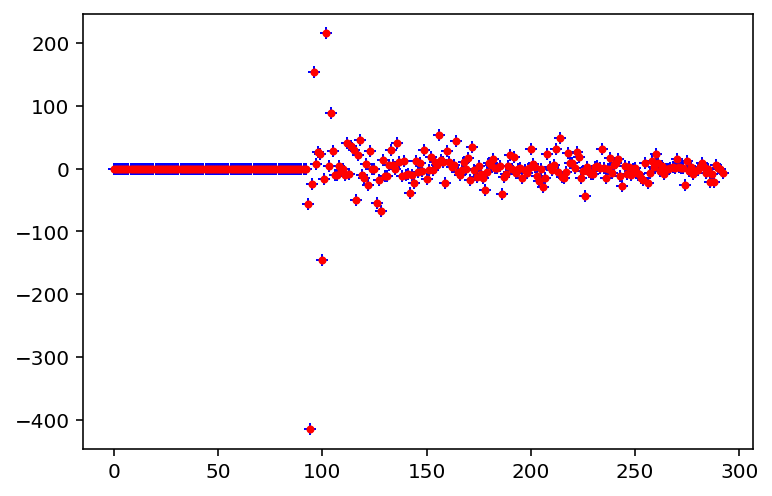

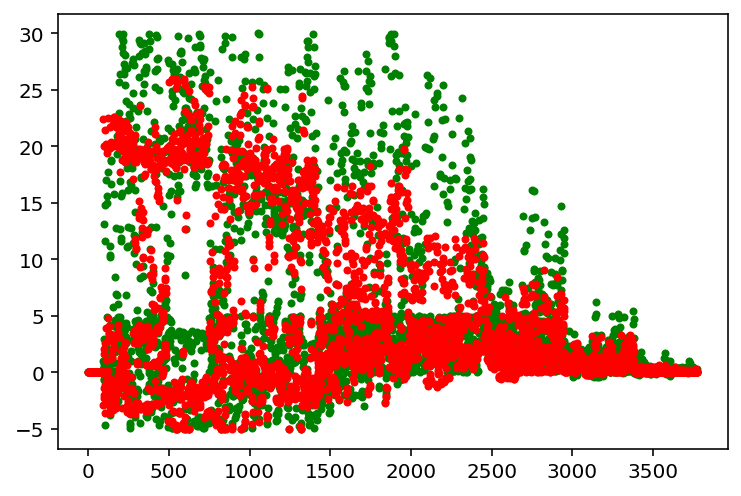

In [69]:
ret = lsqlin(
    operator_eigen * np.sqrt(weighting_vector_eigen[:, None]),
    data_vector_eigen * np.sqrt(weighting_vector_eigen),
    0,
    AAA,  # A=None, inequality operator
    bbb,  # b=None, inequality vector
    None,
    None,
    None,
    None,
    None,
    opts,
)


# Make a pseudostate vector for the eigenvalue case (just for comparision)
ret_state_vector = np.array(ret["x"]).flatten()

estimation_eigen_ret = addict.Dict()
estimation_eigen_ret.state_covariance_matrix = np.linalg.inv(
    operator_eigen.T * weighting_vector_eigen @ operator_eigen
)
estimation_eigen_ret.state_vector = ret_state_vector
forward_data_vector_eigen = operator_eigen @ estimation_eigen_ret.state_vector
estimation_eigen_ret.operator = operator_eigen
post_process_estimation_eigen(estimation_eigen_ret, operators, station, index)


ret_pseudo_state_vector = np.zeros_like(estimation.state_vector)
ret_pseudo_state_vector[0 : 3 * index.n_blocks] = estimation_eigen_ret.state_vector[
    0 : 3 * index.n_blocks
]
ret_pseudo_state_vector[3 * index.n_blocks : :] = estimation_eigen_ret.tde_rates

plt.plot(estimation_eigen.state_vector, "b+")
plt.plot(np.array(ret["x"]).flatten(), "r.")
plt.show()

# plt.plot(estimation_eigen.pseudo_state_vector, "b+")
plt.plot(ret_pseudo_state_vector, "g.")
plt.plot(np.array(ret_bounded["x"]).flatten(), "r.")

plt.show()

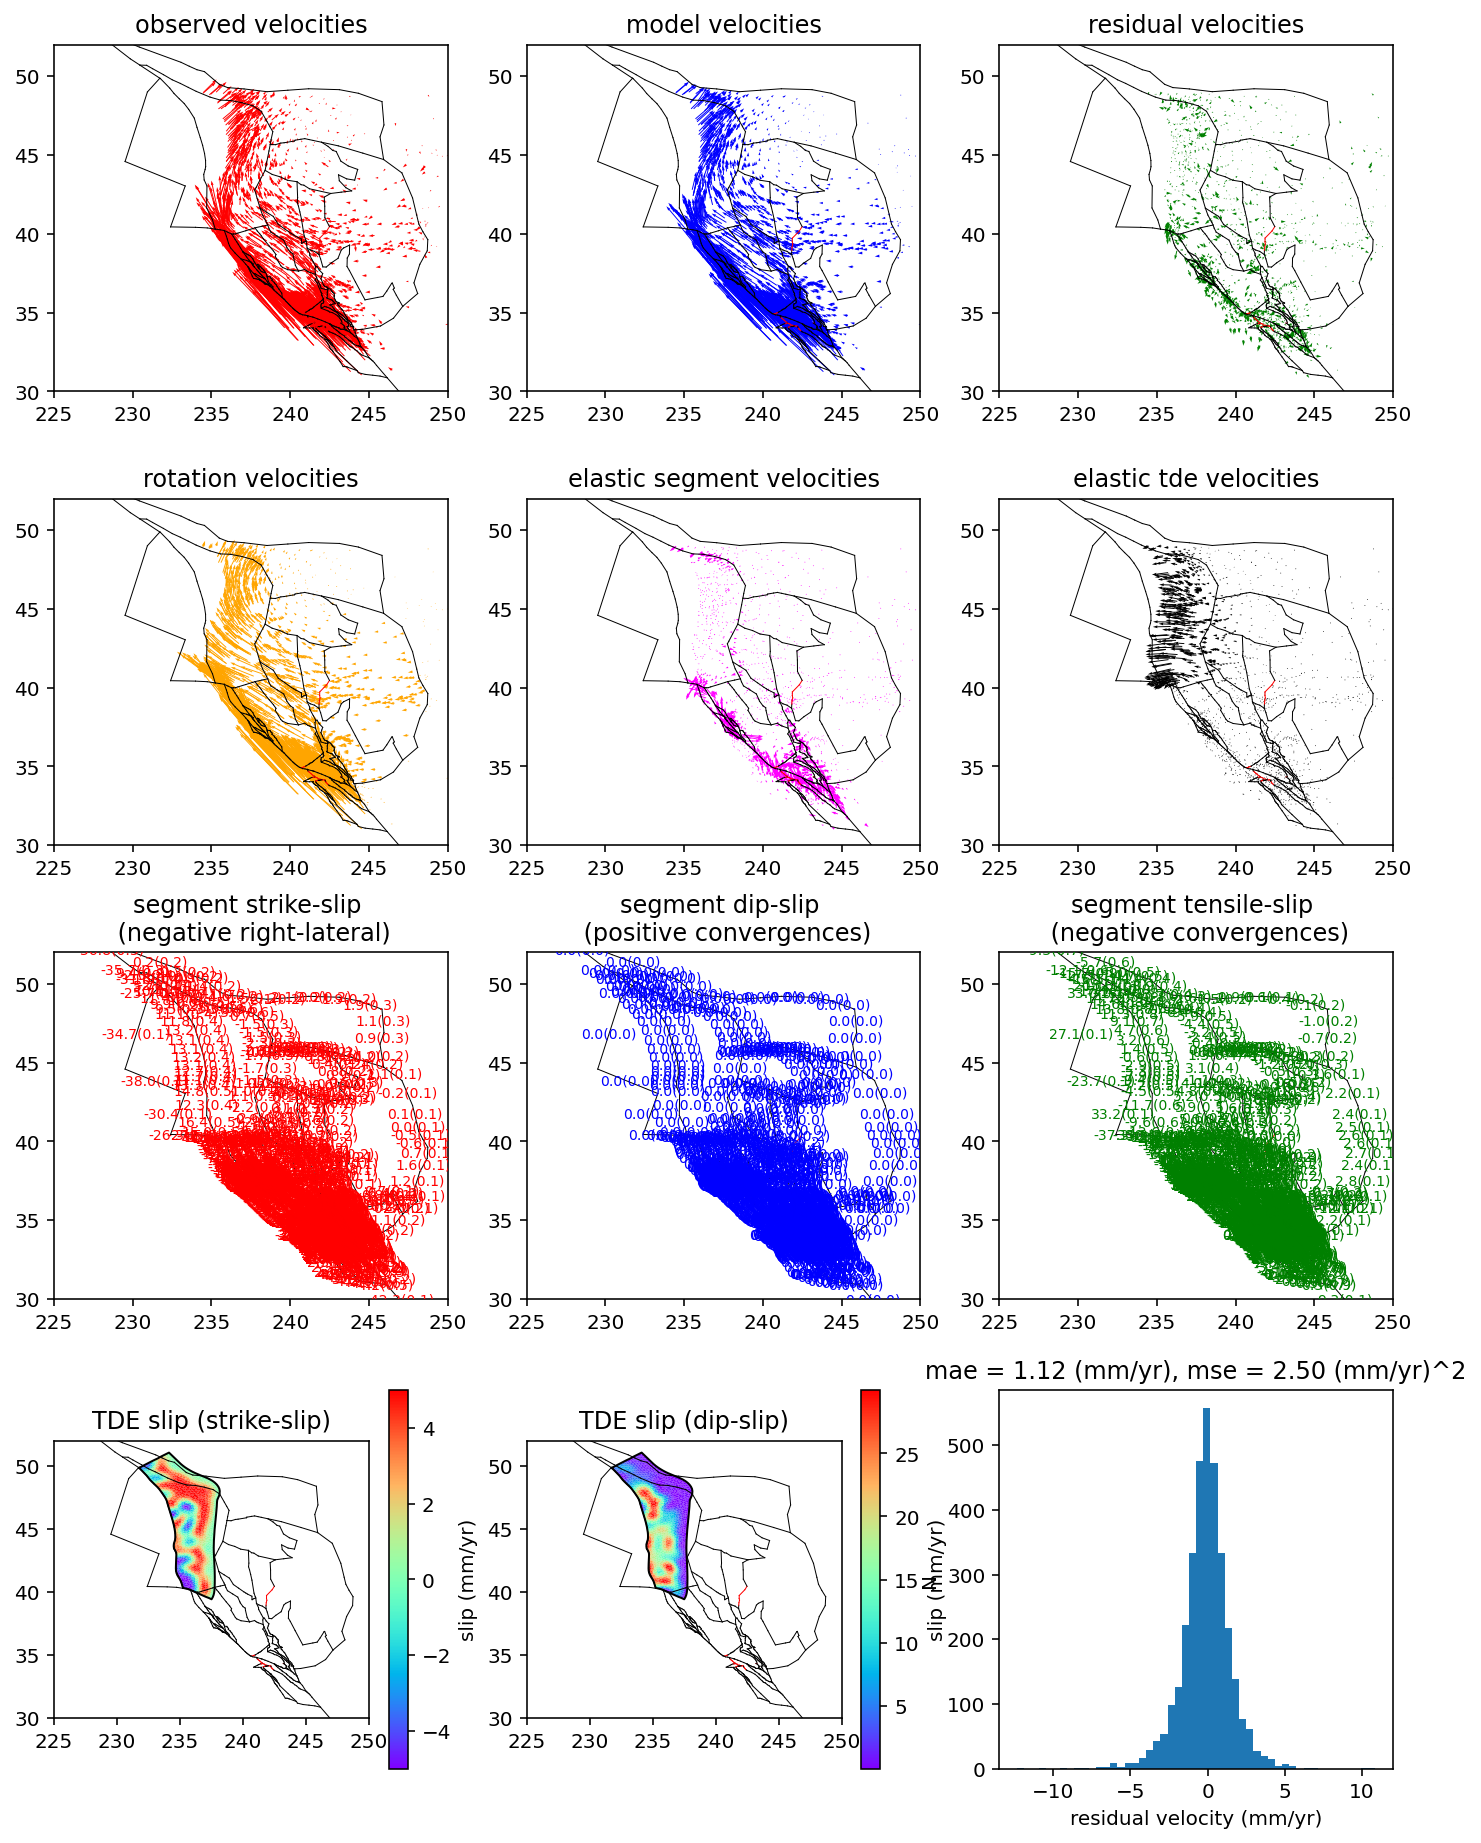

2024-06-21 16:40:02.887 | SUCCESS  | celeri.celeri:plot_estimation_summary:4915 - Wrote figures../runs/2024-06-21-13-40-53/plot_estimation_summary.(pdf, png)


<Figure size 432x288 with 0 Axes>

In [74]:
estimation_eigen.operator = operator_eigen
estimation_eigen.state_vector = ret_state_vector
post_process_estimation_eigen(estimation_eigen, operators, station, index)
celeri.plot_estimation_summary(
    command,
    segment,
    station,
    meshes,
    estimation_eigen,
    lon_range=command.lon_range,
    lat_range=command.lat_range,
    quiver_scale=command.quiver_scale,
)

array([3372, 3373, 3374])

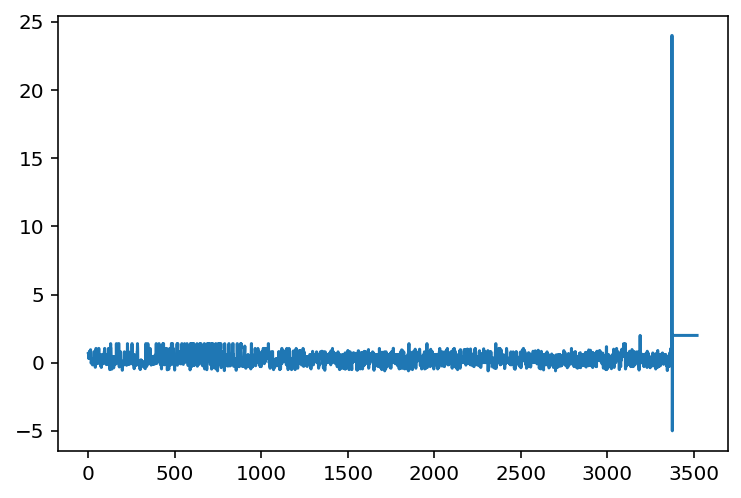

In [70]:
plt.plot(np.log10(weighting_vector_eigen))
np.where(weighting_vector_eigen == np.max(weighting_vector_eigen))[0]

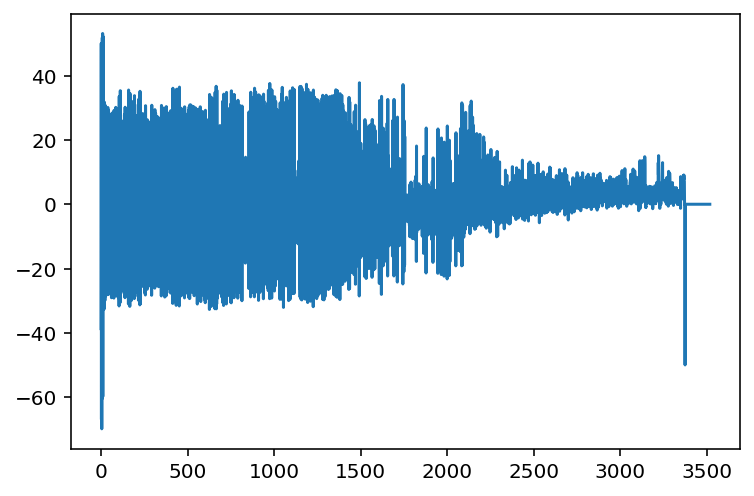

In [71]:
plt.plot(data_vector_eigen)

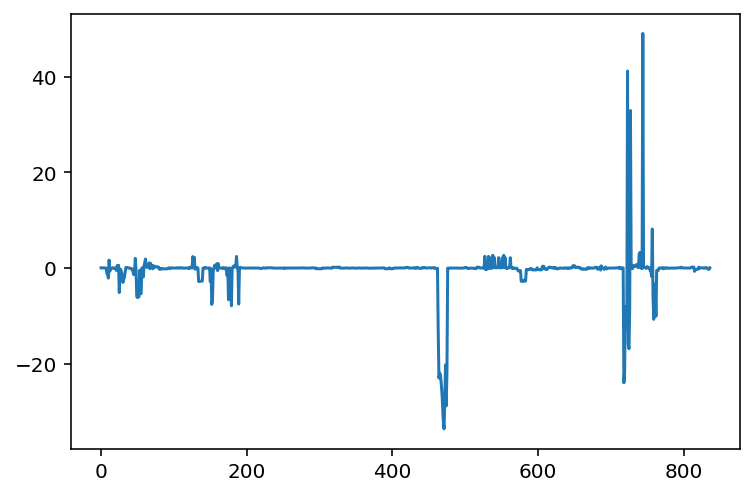

In [77]:
plt.plot(estimation.strike_slip_rates - estimation_eigen.strike_slip_rates)

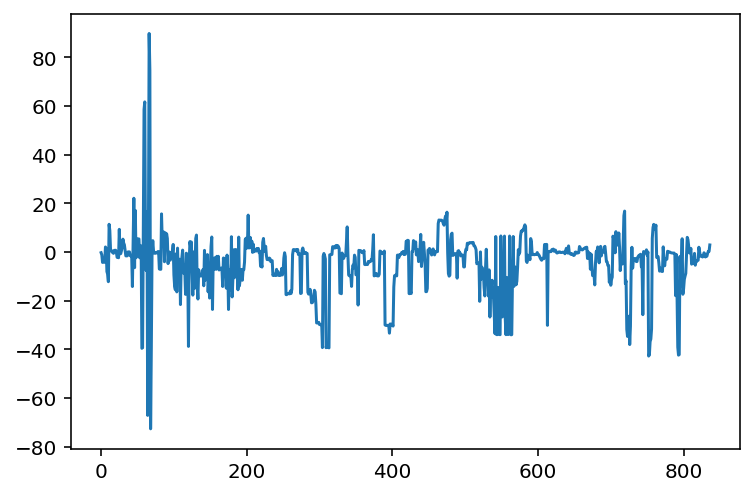

In [75]:
plt.plot(estimation_eigen.strike_slip_rates)